In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)

print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_usgs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

cfe_usgs.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')

initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

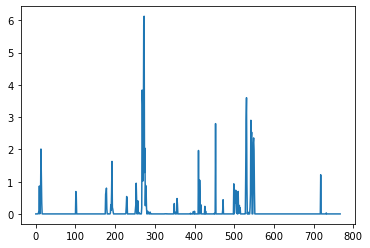

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []
cfe_def = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    cfe_def.append(soil_reservoir_storage_deficit)
    storage_max_m= cfe_peturbed.get_value("storage_max_out_m")
    
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting

    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf   
    enkf.set_value('storage_max_m',storage_max_m)
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    #enkf_validity=enkf.set_value('validity',validity)
    enkf.update()

    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)

    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')


    # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor    
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)

    cfe_analysis.update() #get new streamflow value based on state var change
    # set them in to pert
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
 
# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.33997484961299995
EnKF Code predicted, X Post [167.15384374]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.09183353053238519
EnKF Code predicted, X Post [161.45057095]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.0348150564718811
EnKF Code predicted, X Post [156.45860674]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02344144940103099
EnKF Code predicted, X Post [151.51050288]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021253274385590992
EnKF Code predicted, X Post [148.93103111]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.0208353920052049
EnKF Code predicted, X Post [145.39409318]
 warnin

EnKF Code predicted, X Post [75.23442106]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [74.33328833]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [73.9443001]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [72.61250967]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [73.66552141]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [74.96904995]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073

EnKF Code predicted, X Post [46.70707603]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [46.21871367]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [45.66419511]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [46.92195278]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [45.61202443]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [44.78553231]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.0207

EnKF Code predicted, X Post [38.30398845]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [38.20472944]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [39.21988931]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [38.60352711]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [38.91689205]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [39.99642827]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.0207

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


EnKF Code predicted, X Post [55.73553814]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [55.94071425]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [56.14790206]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code 

Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [40.87989708]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [40.23445398]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [39.70088385]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [39.84446526]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [38.78908611]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [38.46082884]
 warning val

EnKF Code predicted, X Post [71.62805474]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [70.60861156]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [70.19957475]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [68.59632622]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [69.14567795]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [67.96968051]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.0207

EnKF Code predicted, X Post [28.28221829]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [27.2351017]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [26.79736014]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [26.80921885]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [26.63066133]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [26.39509646]
 warning validity is zero
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073

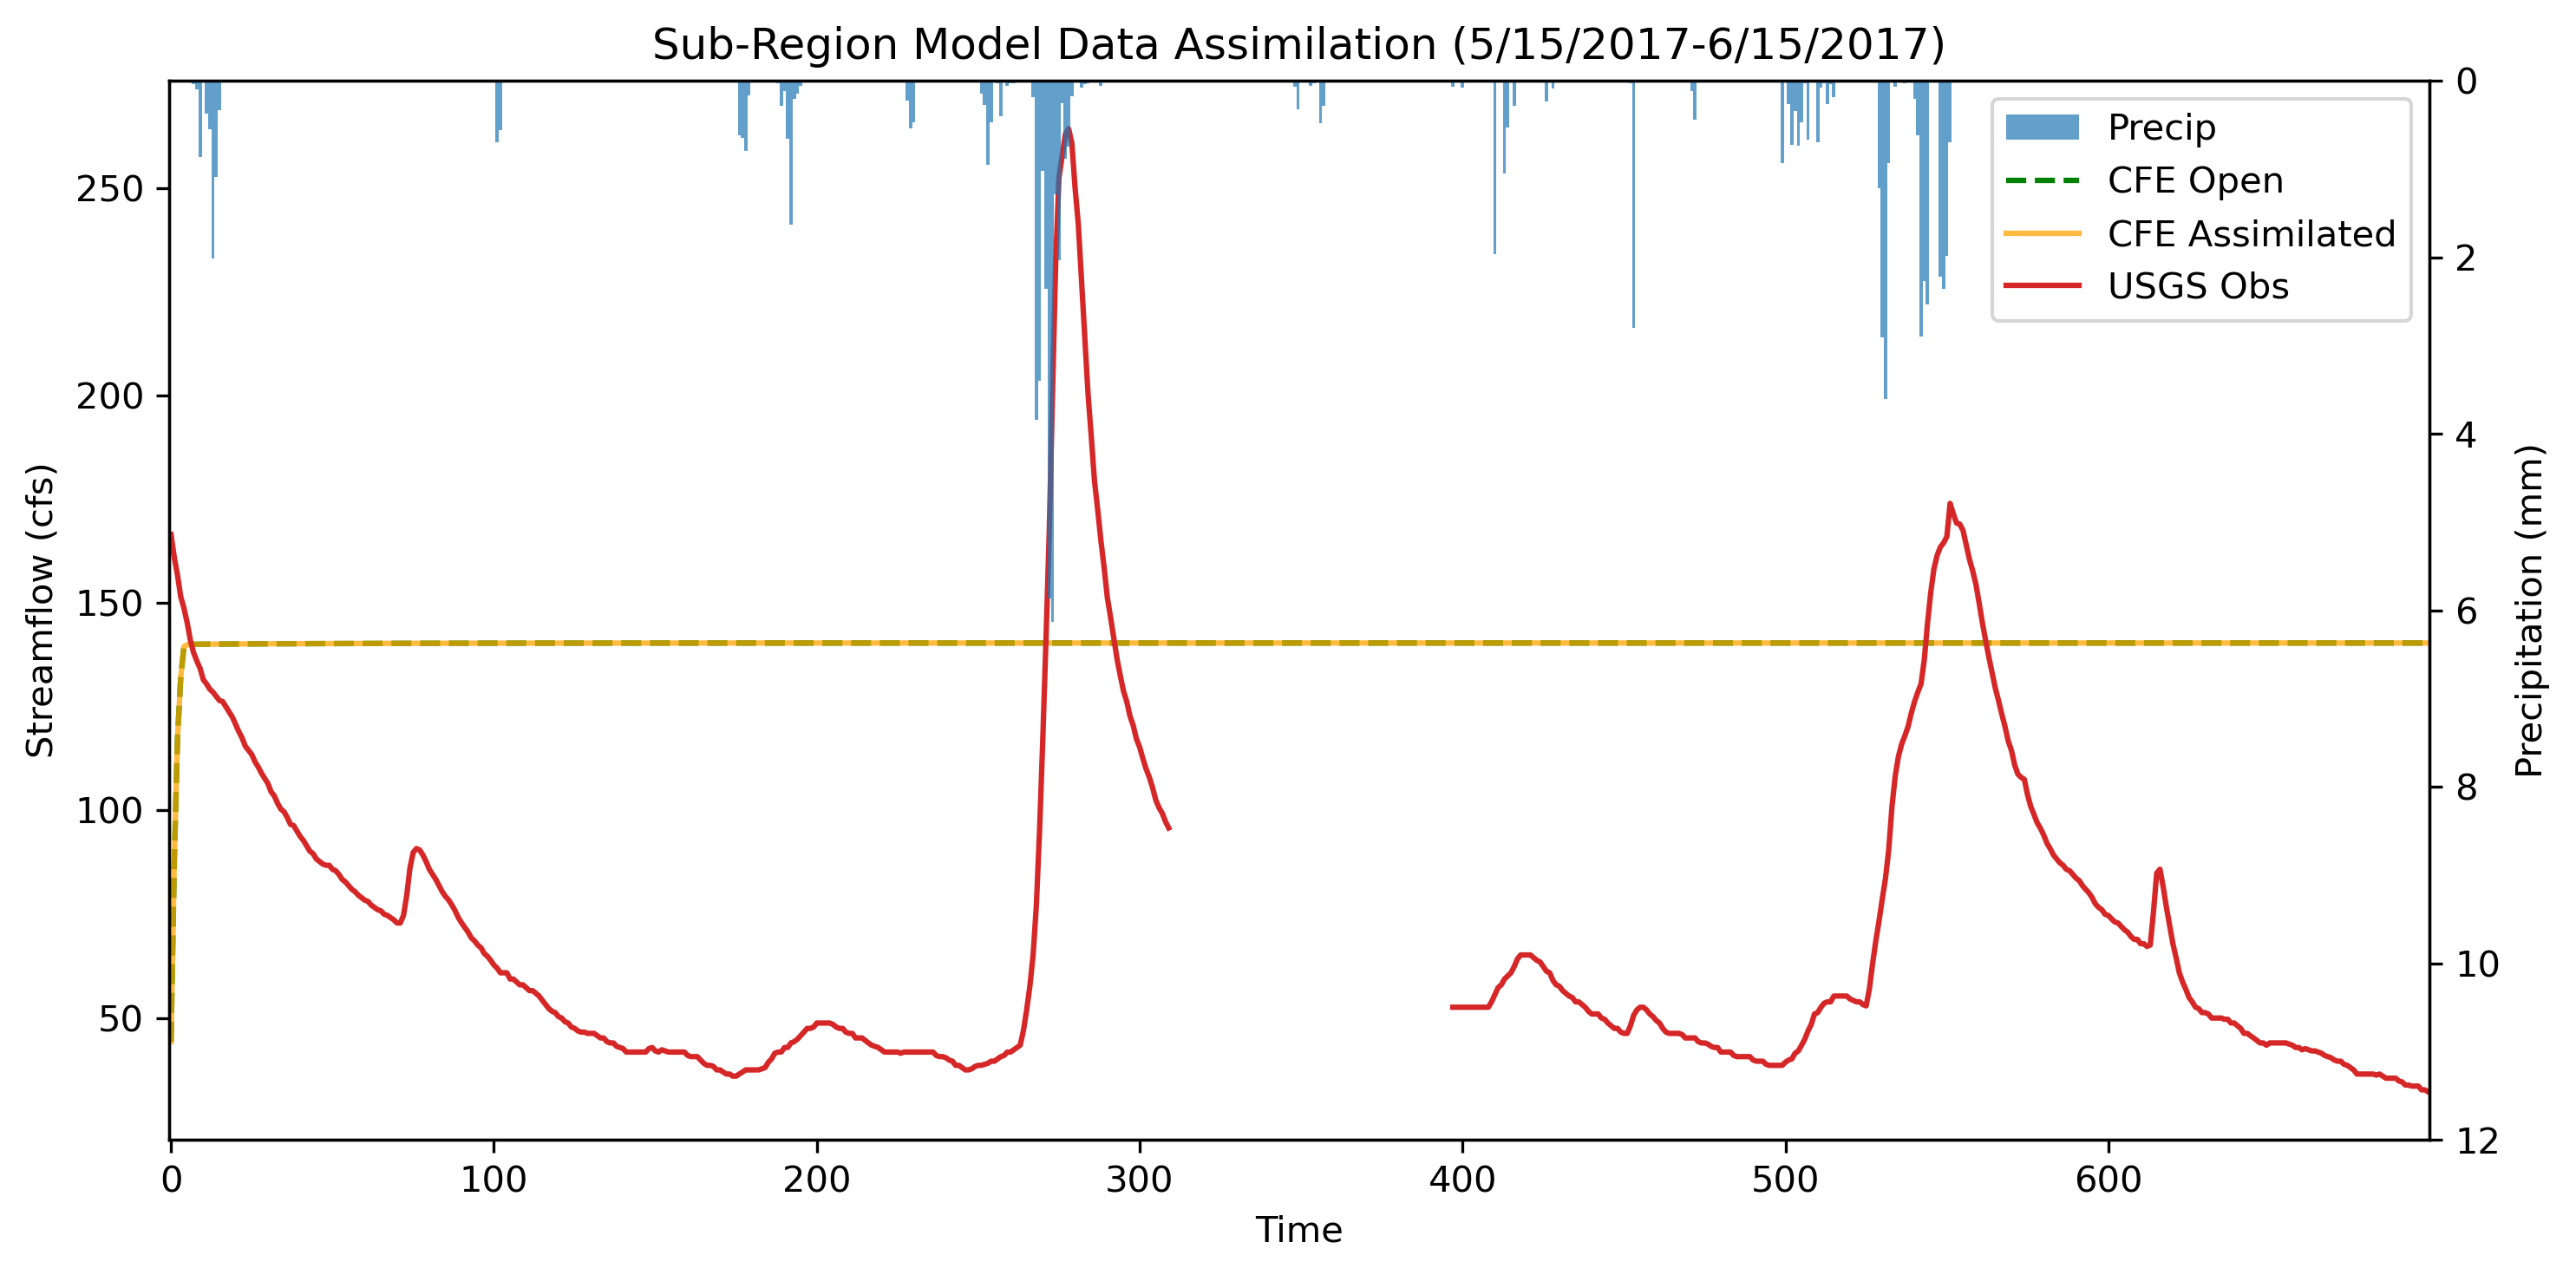

In [7]:
istart_plot=0
iend_plot=700
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,400,1)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', linestyle='dashed', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', label = 'USGS Obs')
#Obs, = ax1.plot(x, cfeUSGS[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed',label = 'USGS Obs')

plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [8]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,166.500,44.313801,44.313801
1,161.000,87.390843,87.390843
2,156.750,117.307755,117.307755
3,151.500,132.067236,132.067236
4,148.750,139.531826,139.531826
...,...,...,...
719,28.400,140.358767,140.358767
720,28.175,140.358767,140.358767
721,28.400,140.358767,140.358767
722,27.500,140.358767,140.358767


In [9]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= -0.14637456242691618
KGE_open= -7.795165491422972
NSE_open= -404.9815494899798
PBias= 52.218658318423735
r_analysis= -0.14637456242691618
KGE_analysis= -7.795165491422972
NSE_analysis= -404.9815494899798
PBias= 52.218658318423735
mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 140.0870305259587
STD_open= 4.168444322807014
mean_analysis= 140.0870305259587
STD_analysis= 4.168444322807014
